<a href="https://colab.research.google.com/github/rishabhm4/Densenet---Keras/blob/master/Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

[8]


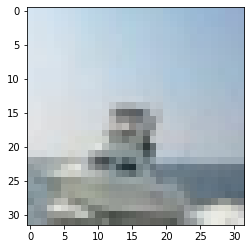

In [54]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32,32,3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=40000).batch(128).repeat()
print(train_labels[100])
plt.imshow(train_images[100], cmap="Greys_r")

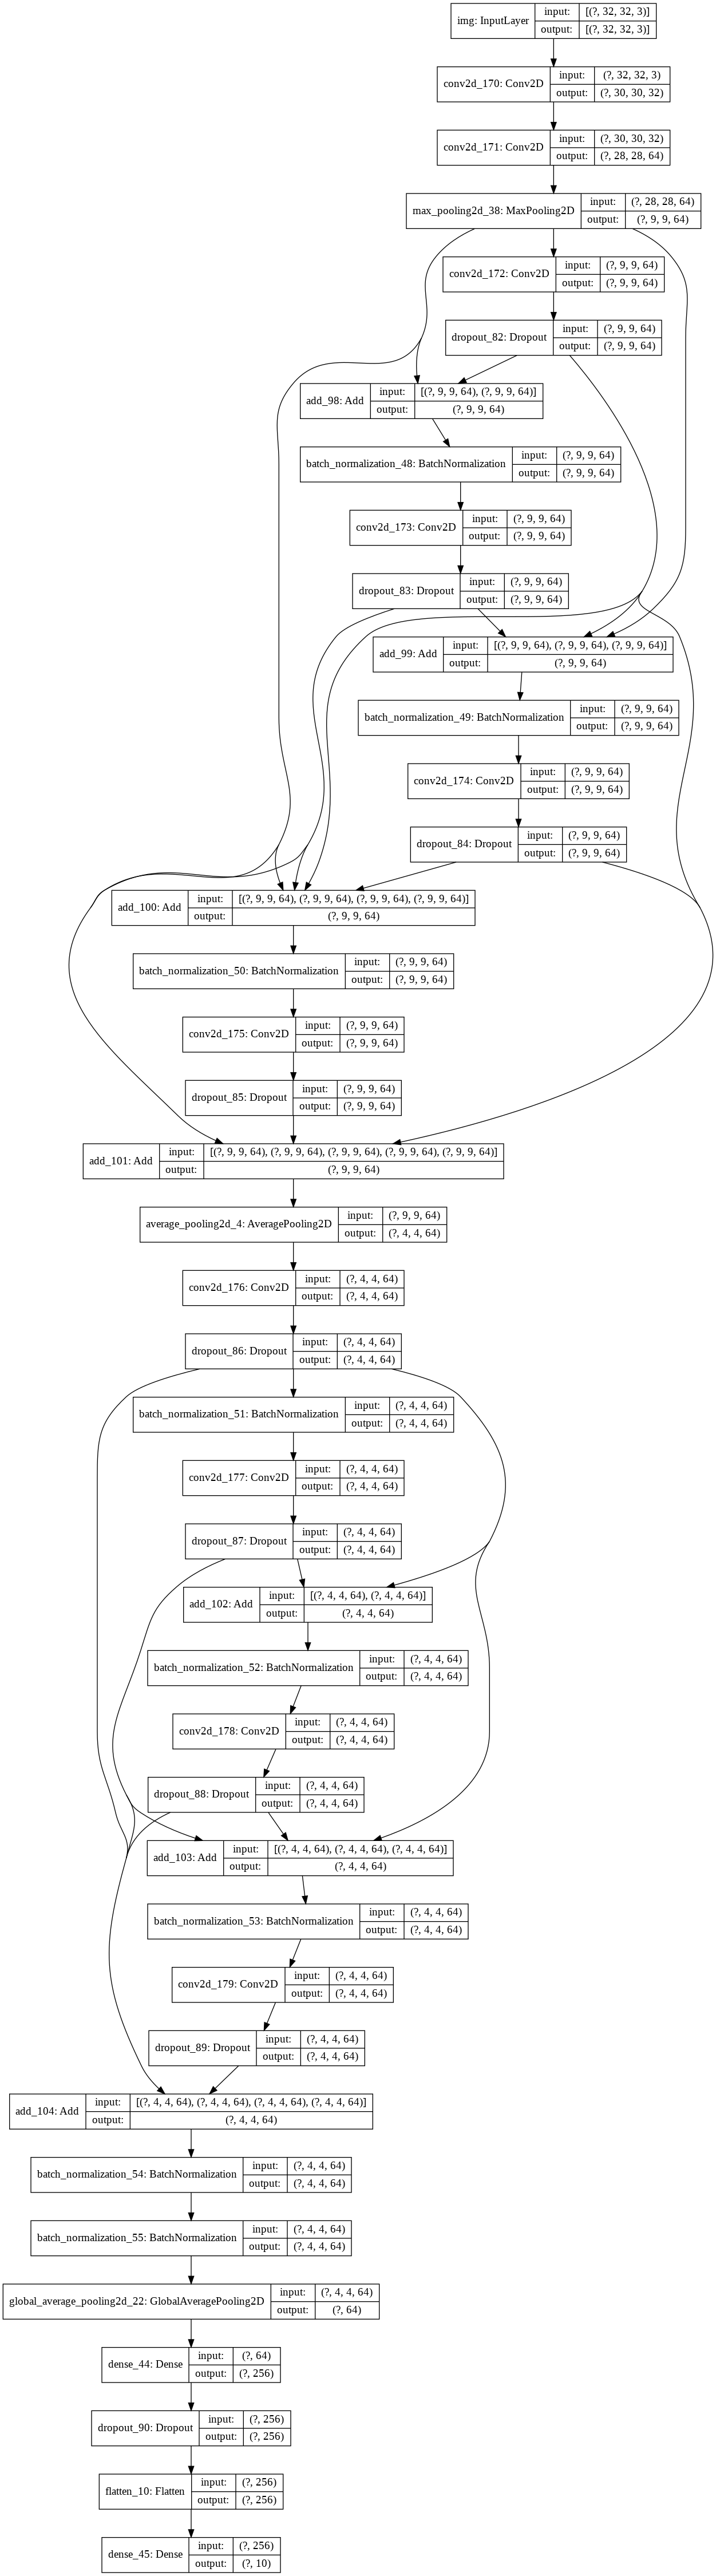

In [55]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

##Dense Block1##################################################################
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Dropout(0.2)(x)
block1=x
block_2_output = layers.add([block1, block_1_output])
block_2_output =  tf.keras.layers.BatchNormalization()(block_2_output)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Activation('relu')(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Dropout(0.2)(x)
block2=x
block_3_output = layers.add([block2, block_1_output,block1])
block_3_output =  tf.keras.layers.BatchNormalization()(block_3_output)

x= layers.Conv2D(64, 3, activation='relu', padding='same')(block_3_output)
x = layers.Dropout(0.2)(x)
block3=x
block_4_output = layers.add([x, block_1_output,block1,block2])
block_4_output =  tf.keras.layers.BatchNormalization()(block_4_output)

x= layers.Conv2D(64, 3, activation='relu', padding='same')(block_4_output)
x = layers.Dropout(0.2)(x)
block4=x
block_5_output = layers.add([x, block_1_output,block1,block2,block3])
#############################Transition layer###################################

#block_4_output = layers.add([x, block_1_output,block_2_output,block_3_output])
#x = layers.MaxPooling2D(3)(x)
x = tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), strides=2)(block_5_output)

## Dense block2 ################################################################
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
block11=x
#block_12_output = layers.add([block11, block_12_output])
block_11_output =  tf.keras.layers.BatchNormalization()(x)



x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_11_output)
x = layers.Dropout(0.2)(x)
block12=x
block_12_output = layers.add([x, block11])
block_12_output =  tf.keras.layers.BatchNormalization()(block_12_output)


x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_12_output)
x = layers.Dropout(0.2)(x)
block13=x
block_13_output = layers.add([x, block11,block12])
block_13_output =  tf.keras.layers.BatchNormalization()(block_13_output)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_13_output)
x = layers.Dropout(0.2)(x)
#block14=x
block_14_output = layers.add([x, block11,block12,block13])
block_14_output =  tf.keras.layers.BatchNormalization()(block_14_output)

################################################################################



x = tf.keras.layers.BatchNormalization()(block_14_output)
x = layers.GlobalAveragePooling2D()(x)




#x = layers.Conv2D(64, 3, activation='relu')(x)
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
flat = tf.keras.layers.Flatten()(x)
outputs = layers.Dense(10)(flat)

opt = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model = keras.Model(inputs, outputs, name='densenet')
keras.utils.plot_model(model, 'mini_densenet.png', show_shapes=True)

In [56]:
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 28, 28, 64)   18496       conv2d_170[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 9, 9, 64)     0           conv2d_171[0][0]                 
___________________________________________________________________________________________

In [0]:

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

In [0]:
# stereotypical train-step-with-function-annotation
train_steps = 2500
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [61]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()

Loss: 0.7471023797988892 Accuracy: 0.671875
took 1.894205093383789 seconds

Loss: 0.6820685863494873 Accuracy: 0.75
took 64.46642971038818 seconds

Loss: 0.8641605377197266 Accuracy: 0.65625
took 61.71558117866516 seconds

Loss: 0.8617900013923645 Accuracy: 0.6953125
took 61.71938133239746 seconds

Loss: 0.7690670490264893 Accuracy: 0.7109375
took 62.23833084106445 seconds

Loss: 0.5754369497299194 Accuracy: 0.8125
took 61.641547441482544 seconds

Loss: 0.560519814491272 Accuracy: 0.7578125
took 61.61782693862915 seconds

Loss: 0.6001949310302734 Accuracy: 0.8046875
took 61.459413290023804 seconds

Loss: 0.5586341023445129 Accuracy: 0.8125
took 61.53166151046753 seconds

Loss: 0.47838789224624634 Accuracy: 0.828125
took 61.46290636062622 seconds

Loss: 0.5676087737083435 Accuracy: 0.8203125
took 61.68395686149597 seconds

Loss: 0.6931507587432861 Accuracy: 0.8125
took 64.36668276786804 seconds

Loss: 0.47557327151298523 Accuracy: 0.8203125
took 61.32382869720459 seconds

Loss: 0.585531

In [63]:
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32,32,3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7898>

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          validation_split=0.2)